#### Evaluation Notebook for batch-generated explanations

#### Setup

In [104]:
import os
import pandas as pd
import numpy as np
import pickle
from importlib import reload
import lime.lime_rdf
import logging
import random
import seaborn as sns
from matplotlib import pyplot as plt
from rdflimeConfig import datasets, load_dataset, split_dataset

reload(lime.lime_rdf)
from lime.lime_rdf import LimeRdfExplainer

logging.basicConfig(level=logging.WARN)

# 0: Metacritic-Movies
# 1: Metacritic-Albums
# 2: Forbes-Companies
# 3: Mercer-Cities
# 4: AAUP-Universities
# -> See rdflimeConfig.py
explored_dataset_idx = 0
algo = "cbow"
vsize = 100

dataset_full, dataset_entities = load_dataset(datasets[explored_dataset_idx], fixed=True)
cfg = datasets[explored_dataset_idx]
uri_col = cfg["columns"]["uri_fixed"]
label_col = cfg["columns"]["label"]

# Will yield the same train/test split that has been used for training the final classifier
dataset_train, dataset_test = split_dataset(dataset_full, cfg, randomize=True)

# Load classifier
with open(os.path.join(cfg["location"], "classifiers", f"svc_10_{algo}_{vsize}"), "rb") as file:
    clf = pickle.load(file)

# Load RDF2Vec Transformer
with open(os.path.join(cfg["location"], "transformers", f"rdf2vec_transformer_{algo}_{vsize}"), "rb") as file:
    rdf2vec_transformer = pickle.load(file)

explainer = LimeRdfExplainer(
    transformer=rdf2vec_transformer, 
    entities=dataset_entities,
    class_names=clf.classes_,
    kernel=None,
    kernel_width=25,
    verbose=False,
    feature_selection="auto",
    random_state=42
)
explainer.use_w2v_freeze = False

entity_kind = cfg["entity"]
print(f"Ready to explain {algo}_{vsize} classifier predictions for {entity_kind}.")



Ready to explain cbow_100 classifier predictions for movies.


In [64]:
def check_explanation(explainer, explained_entity_uri, triple):
    if not triple:
        triple = random.choice(list(explainer.indexed_walks.walks_as_triples(explainer.indexed_walks.walks(explained_entity_uri))))

    modified_walks = explainer.get_perturbed_walks(explained_entity_uri, added_triples=[], removed_triples=[triple])
    
    embedding = explainer.get_perturbed_embedding(explained_entity_uri, modified_walks)

    new_prediction = clf.predict_proba([embedding])
    return new_prediction

In [65]:
import pickle

with open("rows.obj", "wb") as f:
    pickle.dump(rows, f)

In [19]:
rows = []

In [ ]:
exp_path = os.path.join(cfg["location"], "explanations")
files = [f for f in os.listdir(exp_path) if os.path.isfile(os.path.join(exp_path, f))]

top_n_direction_relevant = 10


for file in files:

    with open(os.path.join(exp_path, file), "rb") as f:
        data, probabilities, distances, explanation, prediction, indexed_walks, entity_uri, entity_idx = pickle.load(f)

    prediction = prediction[0]
    predicted_idx = np.argmax(prediction)
    predicted_label = explanation.class_names[predicted_idx]
    predicted_label_probability = prediction[predicted_idx]
    print(f"{entity_idx} {entity_uri}", f"classified as {predicted_label} ({predicted_label_probability})", prediction)

    # Hack necessary since we do not have explanations for both classes in the binary datasets
    target_idx = 1 if explored_dataset_idx < 2 else predicted_idx
    exp_list = explanation.as_list(target_idx)

    # 1 == "positive", -1 == "negative"
    expected_direction = 1 if predicted_idx == target_idx else -1

    n_zeros = 0
    n_correct_direction = 0
    for index, exp in enumerate(exp_list):
        if not exp[1]:
            n_zeros += 1
            continue
        
        if index < top_n_direction_relevant:
            correct_direction = expected_direction * exp[1] > 0
            if correct_direction:
                n_correct_direction += 1
            #print(expected_direction, exp, correct_direction)

    top_exp_ratio = abs(exp_list[-1][1] / exp_list[0][1])

    
    top_triple = exp_list[0][0]
    expected_drift = -exp_list[0][1] # When removing a positive triple, the prediction should become more negative
    
    # Remove the top triple and check the influence on the classifier
    top_prediction = check_explanation(explainer, entity_uri, top_triple)[0][predicted_idx]
    top_drift = top_prediction - predicted_label_probability

    # Remove a random triple and check the influence on the classifier
    random_prediction = check_explanation(explainer, entity_uri, None)[0][predicted_idx]
    random_drift = random_prediction - predicted_label_probability

    print(top_prediction, top_drift)
    print(random_prediction, random_drift)

    rows.append({
        "dataset": explored_dataset_idx,
        "entity_idx": entity_idx,
        "n_zeros": n_zeros,
        "n_correct_direction": n_correct_direction,
        "r2_score": explanation.score[target_idx],
        "prediction_confidence": predicted_label_probability,
        "top_exp_ratio": top_exp_ratio,
        "expected_drift": expected_drift,
        "drift_top_triple": top_drift,
        "drift_random_triple": random_drift
    })


In [135]:
df = pd.DataFrame(rows)

# Remove The_Matrix, a movie that has been used as sample but is not within the test dataset
df = df[(df.entity_idx!=92) | (df.dataset!=0)]
df


,dataset,entity_idx,n_zeros,n_correct_direction,r2_score,prediction_confidence,top_exp_ratio,expected_drift,drift_top_triple,drift_random_triple
0,0,13,0,1,0.044927,0.999991,0.282827,-2.807123e-08,-4.060937e-08,9.615500e-08
1,0,1459,0,2,0.060993,0.999866,0.336798,-2.333830e-07,-3.311428e-06,-4.546463e-06
2,0,647,0,7,0.129828,0.999999,0.067578,6.440062e-09,4.008803e-09,7.119107e-09
3,0,20,0,4,0.118513,0.921304,0.082061,-2.646734e-04,-3.848509e-04,-3.860730e-04
4,0,766,0,5,0.107774,1.000000,0.113905,6.775205e-11,-4.048095e-12,-5.707124e-11
...,...,...,...,...,...,...,...,...,...,...
632,4,491,0,1,0.131533,0.547301,0.123384,2.374564e-04,-6.243187e-04,-3.550308e-04
633,4,191,0,10,0.069224,0.475502,0.158990,-1.686853e-04,5.973358e-04,3.595909e-04
634,4,252,0,7,0.120657,0.713607,0.077726,2.621785e-04,9.470254e-07,-4.619157e-04
635,4,315,0,9,0.096430,0.652067,0.105902,-3.834073e-04,1.626358e-03,2.232639e-03


#### n_correct_direction
Plot n_correct_direction, i.e. the nuber of triples among the top 10 that are in the "expected" direction.

In [194]:
sns.countplot(x=df[df.dataset <= 1].n_correct_direction, color="#0C479C", saturation=0.5)
plt.xlabel("# of triples in the expected direction")
plt.ylabel("count of explanations")
plt.savefig("expected-triple-exp-binary.pdf")
plt.close()

sns.countplot(x=df[df.dataset > 1].n_correct_direction, color="#0C479C", saturation=0.5)
plt.xlabel("# of triples in the expected direction")
plt.ylabel("count of explanations")
plt.savefig("expected-triple-exp-multi.pdf")
plt.close()

display(df[df.dataset <= 1].n_correct_direction.describe())
display(df[df.dataset > 1].n_correct_direction.describe())
print("---")
display(df[df.dataset <= 1].prediction_confidence.describe())
df[df.dataset > 1].prediction_confidence.describe()

count    360.000000
mean       4.422222
std        2.436847
min        0.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       10.000000
Name: n_correct_direction, dtype: float64

count    276.000000
mean       4.905797
std        3.042458
min        0.000000
25%        2.000000
50%        5.000000
75%        7.000000
max       10.000000
Name: n_correct_direction, dtype: float64

---


count    360.000000
mean       0.967444
std        0.086557
min        0.516628
25%        0.985517
50%        0.999145
75%        0.999997
max        1.000000
Name: prediction_confidence, dtype: float64

count    276.000000
mean       0.734804
std        0.144440
min        0.408183
25%        0.630817
50%        0.731010
75%        0.870150
max        0.991793
Name: prediction_confidence, dtype: float64

#### R² score

count    636.000000
mean       0.096557
std        0.042314
min        0.000000
25%        0.066612
50%        0.087675
75%        0.114698
max        0.358541
Name: r2_score, dtype: float64

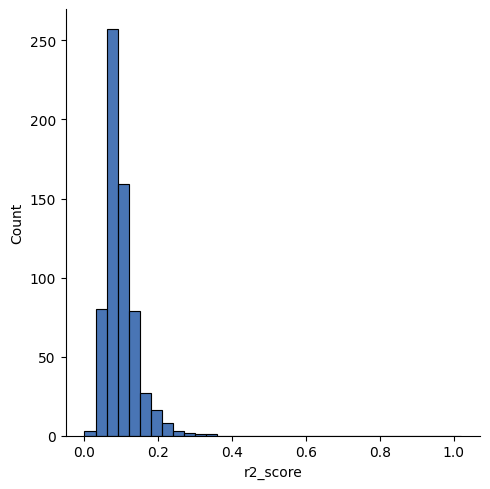

In [199]:
sns.displot(x=df.r2_score.sort_values().reset_index(drop=True), bins=np.arange(0,1.05,0.03), color="#0C479C")
df.r2_score.describe()

#### Top-1 triple prediction change

In [205]:
((df.drift_top_triple / df.expected_drift)  >= 1).describe()

count       636
unique        2
top       False
freq        412
dtype: object

#### Top-1 vs Random-1 prediction change

In [206]:
from scipy.stats import ks_2samp
ks_2samp(df.drift_top_triple, df.drift_random_triple)

KstestResult(statistic=0.03459119496855346, pvalue=0.841623549770212)

In [196]:
df.top_exp_ratio.describe()

count    636.000000
mean       0.157329
std        0.074577
min        0.024015
25%        0.101987
50%        0.141948
75%        0.198008
max        0.468065
Name: top_exp_ratio, dtype: float64

In [74]:
df.abs().drift_top_triple.describe()

count    6.370000e+02
mean     3.036687e-04
std      6.953619e-04
min      0.000000e+00
25%      9.977925e-07
50%      6.534884e-05
75%      3.386152e-04
max      9.489345e-03
Name: drift_top_triple, dtype: float64

In [69]:
df.abs().sum()

dataset                     926.000000
entity_idx               492548.000000
n_zeros                       0.000000
n_correct_direction        2950.000000
r2_score                     61.475454
prediction_confidence       552.082552
top_exp_ratio               100.222583
expected_drift                0.083034
drift_top_triple              0.193437
drift_random_triple           0.218882
dtype: float64

In [80]:
df.n_zeros.describe()

count    637.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: n_zeros, dtype: float64

In [141]:
df[df.dataset < 2].prediction_confidence.describe()

count    360.000000
mean       0.967444
std        0.086557
min        0.516628
25%        0.985517
50%        0.999145
75%        0.999997
max        1.000000
Name: prediction_confidence, dtype: float64

<AxesSubplot:xlabel='n_correct_direction', ylabel='count'>

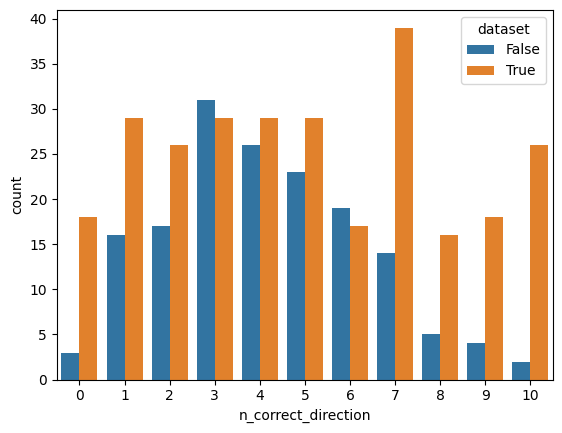

In [60]:
df.n_correct_direction.describe()

count    541.000000
mean       4.439926
std        2.665033
min        0.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       10.000000
Name: n_correct_direction, dtype: float64

In [206]:
# normal distribution -> naive approach would score the same!

In [61]:
df.prediction_confidence.describe()

count    541.000000
mean       0.905417
std        0.137505
min        0.431938
25%        0.856173
50%        0.986332
75%        0.999950
max        1.000000
Name: prediction_confidence, dtype: float64

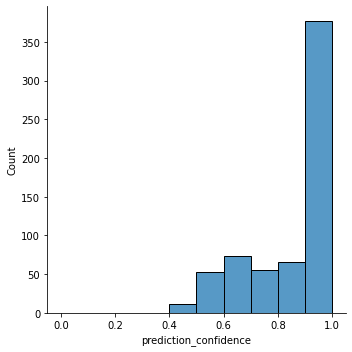

In [94]:
from matplotlib import pyplot as plt
sns.displot(x=df.prediction_confidence.sort_values().reset_index(drop=True), bins=np.arange(0,1.05,0.1))
#sns.lineplot(data=df.prediction_confidence.sort_values().reset_index(drop=True))


count    519.000000
mean       0.096625
std        0.043510
min        0.000000
25%        0.064678
50%        0.088189
75%        0.115569
max        0.358541
Name: r2_score, dtype: float64

('http://dbpedia.org/resource/Category:European_films', 'http://www.w3.org/2004/02/skos/core#broader', 'http://dbpedia.org/resource/Category:Romanian_films')
('http://dbpedia.org/resource/Category:Abortion_by_country', 'http://www.w3.org/2004/02/skos/core#broader', 'http://dbpedia.org/resource/Category:Abortion_in_Romania')
('http://dbpedia.org/resource/Vlad_Ivanov', 'http://dbpedia.org/ontology/occupation', 'http://dbpedia.org/resource/Vlad_Ivanov__1')
('http://dbpedia.org/resource/Cristian_Mungiu', 'http://dbpedia.org/ontology/director', 'http://dbpedia.org/resource/4_Months,_3_Weeks_and_2_Days')
('Abortion in Romania', 'http://www.w3.org/2004/02/skos/core#prefLabel', 'http://dbpedia.org/resource/Category:Abortion_in_Romania')
('http://dbpedia.org/resource/Ratatouille_(film)', 'http://purl.org/dc/terms/subject', 'http://dbpedia.org/resource/Category:Animated_comedy_films')
('http://xmlns.com/foaf/0.1/Person', 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', "http://dbpedia.org/reso

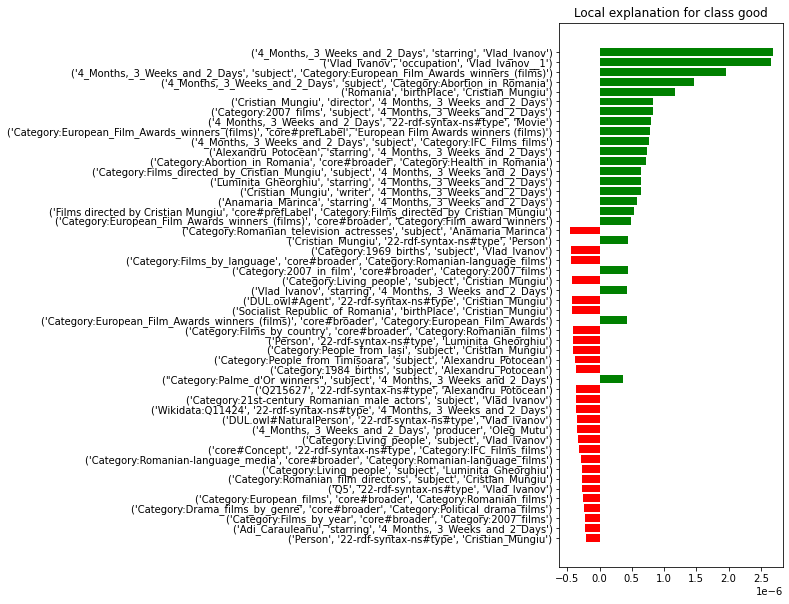

In [34]:
explanations = pd.DataFrame()

for i in range(16):
    with open(f"explanation-{i}", "rb") as f:
        explanation, perturbed_predictions = pickle.load(f)
        entity = movies[i]
        
        for idx, exp in enumerate(explanation.as_list()[:5]):
            entry = {
                "entity_id": i,
                "entity_name": movies[i].split("/")[-1],
                "explanation_index": idx,
                "explanation": exp[0],
                "explanation_indicator": exp[1],
                "original_prediction": clf.predict_proba([rdf2vec_transformer._embeddings[i]])[0][1],
                "new_prediction": check_explanation(entity, exp)[0][1],
            }
            entry["prediction_delta"] = entry["new_prediction"] - entry["original_prediction"]
            entry["explanation_factor"] = entry["prediction_delta"] / entry["explanation_indicator"]
            explanations = explanations.append(entry, ignore_index=True)

        if i==0:
            explanation.domain_mapper.short_uris=True
            explanation.as_pyplot_figure(figsize=(4, 10))
            explanation.domain_mapper.short_uris=False


In [35]:
explanations

,entity_id,entity_name,explanation,explanation_factor,explanation_index,explanation_indicator,new_prediction,original_prediction,prediction_delta
0,0.0,"4_Months,_3_Weeks_and_2_Days","(http://dbpedia.org/resource/4_Months,_3_Weeks...",6.659259,0.0,0.000003,0.993284,0.993266,0.000018
1,0.0,"4_Months,_3_Weeks_and_2_Days","(http://dbpedia.org/resource/Vlad_Ivanov, http...",5.003005,1.0,0.000003,0.993279,0.993266,0.000013
2,0.0,"4_Months,_3_Weeks_and_2_Days","(http://dbpedia.org/resource/4_Months,_3_Weeks...",9.421225,2.0,0.000002,0.993285,0.993266,0.000018
3,0.0,"4_Months,_3_Weeks_and_2_Days","(http://dbpedia.org/resource/4_Months,_3_Weeks...",7.414963,3.0,0.000001,0.993277,0.993266,0.000011
4,0.0,"4_Months,_3_Weeks_and_2_Days","(http://dbpedia.org/resource/Romania, http://d...",16.233061,4.0,0.000001,0.993285,0.993266,0.000019
...,...,...,...,...,...,...,...,...,...
75,15.0,Goodbye_Solo,(http://dbpedia.org/resource/Category:Films_di...,-5.841992,0.0,0.000245,0.686022,0.687451,-0.001430
76,15.0,Goodbye_Solo,"(http://dbpedia.org/resource/Goodbye_Solo, htt...",-2.293056,1.0,0.000242,0.686897,0.687451,-0.000554
77,15.0,Goodbye_Solo,"(http://dbpedia.org/resource/Goodbye_Solo, htt...",-0.345438,2.0,-0.000239,0.687534,0.687451,0.000083
78,15.0,Goodbye_Solo,"(http://dbpedia.org/resource/Goodbye_Solo, htt...",2.407875,3.0,-0.000157,0.687074,0.687451,-0.000377


<AxesSubplot:>

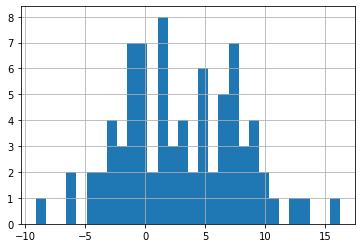

In [36]:
explanations.explanation_factor.hist(bins=30)

In [37]:
explanations.explanation_factor.describe()

count    80.000000
mean      2.935684
std       4.903636
min      -9.112430
25%      -0.872708
50%       2.559983
75%       6.946342
max      16.233061
Name: explanation_factor, dtype: float64

In [38]:
# Fraction of negative explanation_factors
len(explanations[explanations.explanation_factor < 0]) / len(explanations)

0.35

In [39]:
explanations.prediction_delta.abs().sum()

0.01378369022520114

In [40]:
x = 0.014858028851393373